In [ ]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define root path
root_path = '/content/drive/MyDrive/Group-8-Deep-Learning/SAM'

# Change directory to the root path
os.chdir(root_path)

# Get the current working directory and assign it to ROOT
ROOT = os.getcwd()

# Print the ROOT path
print(ROOT)

/content/drive/MyDrive/Group-8-Deep-Learning/SAM


In [ ]:
import cv2
import numpy as np
import roboflow
import supervision as sv
from supervision.utils.file import save_text_file

**Note:** Define an ontology to map class names, the ontology dictionary has the format **{caption: class}**
- caption is the prompt sent to the base model
- class is the label in the generated annotations

In [ ]:
from autodistill.detection import CaptionOntology
ontology_0 = CaptionOntology({"military tank": "tank"})
ontology_1 = CaptionOntology({"bus": "bus"})
ontology_2 = CaptionOntology({"train": "train"})
ontology_3 = CaptionOntology({"boat": "boat"})
ontology_4 = CaptionOntology({"person": "person"})

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install --upgrade protobuf

  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.11.0
    Uninstalling protobuf-3.11.0:
      Successfully uninstalled protobuf-3.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autodist 0.7.0rc2 requires protobuf==3.11.0, but you have protobuf 4.25.3 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


In [ ]:
from autodistill_grounded_sam import GroundedSAM

def process_images(ontology, detect_object):
    ROOT = os.getcwd()
    base_model = GroundedSAM(ontology=ontology)
    dataset = base_model.label(
        input_folder=f"{ROOT}/SAM-input-images/{detect_object}/temp",
        extension=".jpg",
        output_folder=f"{ROOT}/annotations_{detect_object}"
    )

    ANNOTATIONS_DIRECTORY_PATH = f"{ROOT}/annotations_{detect_object}/train/labels"
    IMAGES_DIRECTORY_PATH = f"{ROOT}/annotations_{detect_object}/train/images"
    DATA_YAML_PATH = f"{ROOT}/annotations_{detect_object}/data.yaml"

    dataset = sv.DetectionDataset.from_yolo(
        images_directory_path=IMAGES_DIRECTORY_PATH,
        annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
        data_yaml_path=DATA_YAML_PATH
    )

    SAMPLE_GRID_SIZE = (5, 5)
    SAMPLE_PLOT_SIZE = (16, 16)
    image_names = list(dataset.images.keys())

    mask_annotator = sv.MaskAnnotator()
    box_annotator = sv.BoxAnnotator()
    images = []

    for image_name in image_names:
        image = dataset.images[image_name]
        annotations = dataset.annotations[image_name]
        labels = [dataset.classes[class_id] for class_id in annotations.class_id]

        annotates_image = mask_annotator.annotate(scene=image.copy(), detections=annotations)
        annotates_image = box_annotator.annotate(scene=annotates_image, detections=annotations, labels=labels)
        images.append(annotates_image)

    sv.plot_images_grid(
        images=images,
        titles=image_names,
        grid_size=SAMPLE_GRID_SIZE,
        size=SAMPLE_PLOT_SIZE
    )

## Adding output directory to save images

In [ ]:
import os
import supervision as sv
from autodistill_grounded_sam import GroundedSAM
from PIL import Image

def process_images(ontology, detect_object, output_path):
    ROOT = os.getcwd()
    base_model = GroundedSAM(ontology=ontology)
    dataset = base_model.label(
        input_folder=f"{ROOT}/SAM-input-images/{detect_object}",
        extension=".jpg",
        output_folder=f"{ROOT}/annotations_{detect_object}"
    )

    ANNOTATIONS_DIRECTORY_PATH = f"{ROOT}/annotations_{detect_object}/train/labels"
    IMAGES_DIRECTORY_PATH = f"{ROOT}/annotations_{detect_object}/train/images"
    DATA_YAML_PATH = f"{ROOT}/annotations_{detect_object}/data.yaml"

    dataset = sv.DetectionDataset.from_yolo(
        images_directory_path=IMAGES_DIRECTORY_PATH,
        annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
        data_yaml_path=DATA_YAML_PATH
    )

    SAMPLE_GRID_SIZE = (5, 5)
    SAMPLE_PLOT_SIZE = (16, 16)
    image_names = list(dataset.images.keys())

    mask_annotator = sv.MaskAnnotator()
    box_annotator = sv.BoxAnnotator()
    images = []

    # Create output directory for annotated images
    annotated_images_output_path = os.path.join(output_path, 'annotated_images')
    os.makedirs(annotated_images_output_path, exist_ok=True)

    for image_name in image_names:
        image = dataset.images[image_name]
        annotations = dataset.annotations[image_name]
        labels = [dataset.classes[class_id] for class_id in annotations.class_id]

        annotated_image = mask_annotator.annotate(scene=image.copy(), detections=annotations)
        annotated_image = box_annotator.annotate(scene=annotated_image, detections=annotations, labels=labels)

        # Convert the NumPy array to PIL image
        pil_image = Image.fromarray(annotated_image)

        # Save annotated image using PIL
        annotated_image_filename = f"{image_name}_segmented.jpg"
        annotated_image_path = os.path.join(annotated_images_output_path, annotated_image_filename)
        pil_image.save(annotated_image_path)

        images.append(annotated_image)

    # Plot the images grid
    sv.plot_images_grid(
        images=images,
        titles=image_names,
        grid_size=SAMPLE_GRID_SIZE,
        size=SAMPLE_PLOT_SIZE
    )


## Tank

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/Group-8-Deep-Learning/SAM/SAM-input-images/tank/Copy of 3195670783_55c3da86b1_o.jpg: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Found /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/train/images/Copy of Copy of 4882385257_5db9173182_o.jpg as already present, not moving anything to /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/train/images
Found /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/train/labels/Copy of Copy of 4882385257_5db9173182_o.txt as already present, not moving anything to /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/train/labels
Found /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/valid/images/Copy of Copy of 31683797658_ea837455b3_k.jpg as already present, not moving anything to /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/valid/images
Found /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/valid/labels/Copy of Copy of 31683797658_ea837455b3_k.txt as already present, not moving anything to /content/drive/MyDrive/Group-8-Deep-Learning/SAM/annotations_tank/valid/l

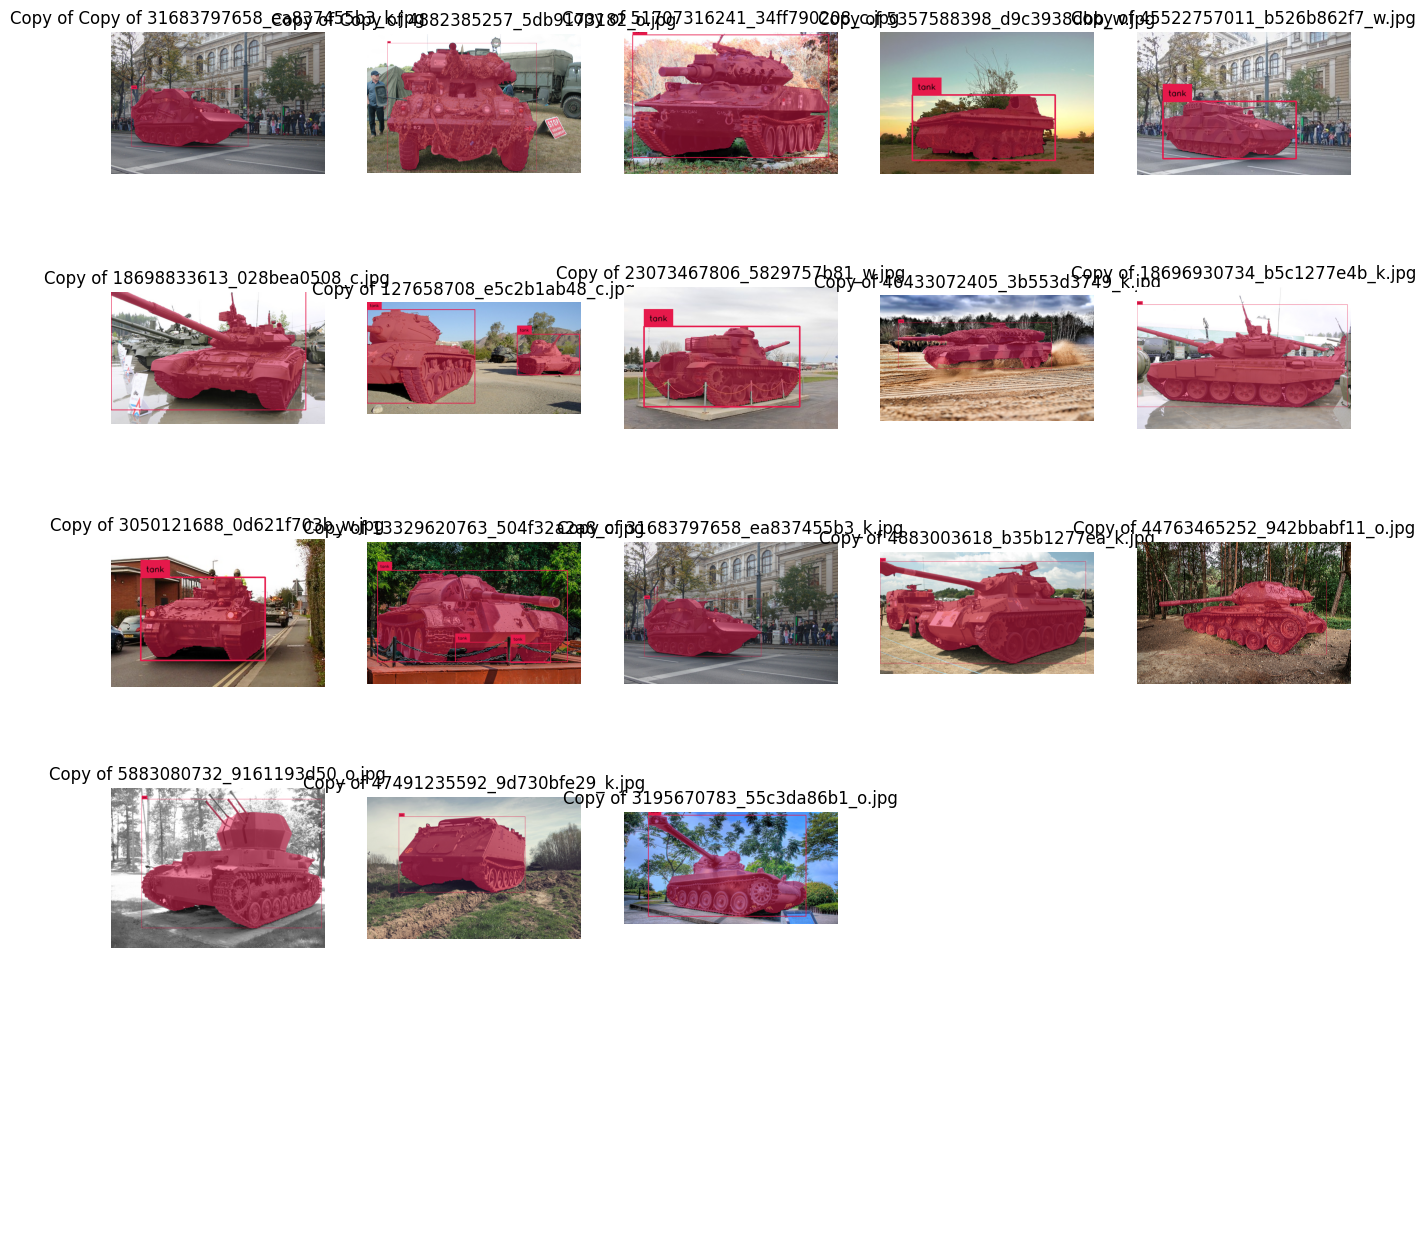

In [ ]:
process_images(ontology_0, "tank", 'output_inference')

## Bus

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/Group-8-Deep-Learning/SAM/SAM-input-images/bus/22501862699_950a0b3949_c.jpg: 100%|██████████| 20/20 [01:05<00:00,  3.30s/it]


Labeled dataset created - ready for distillation.


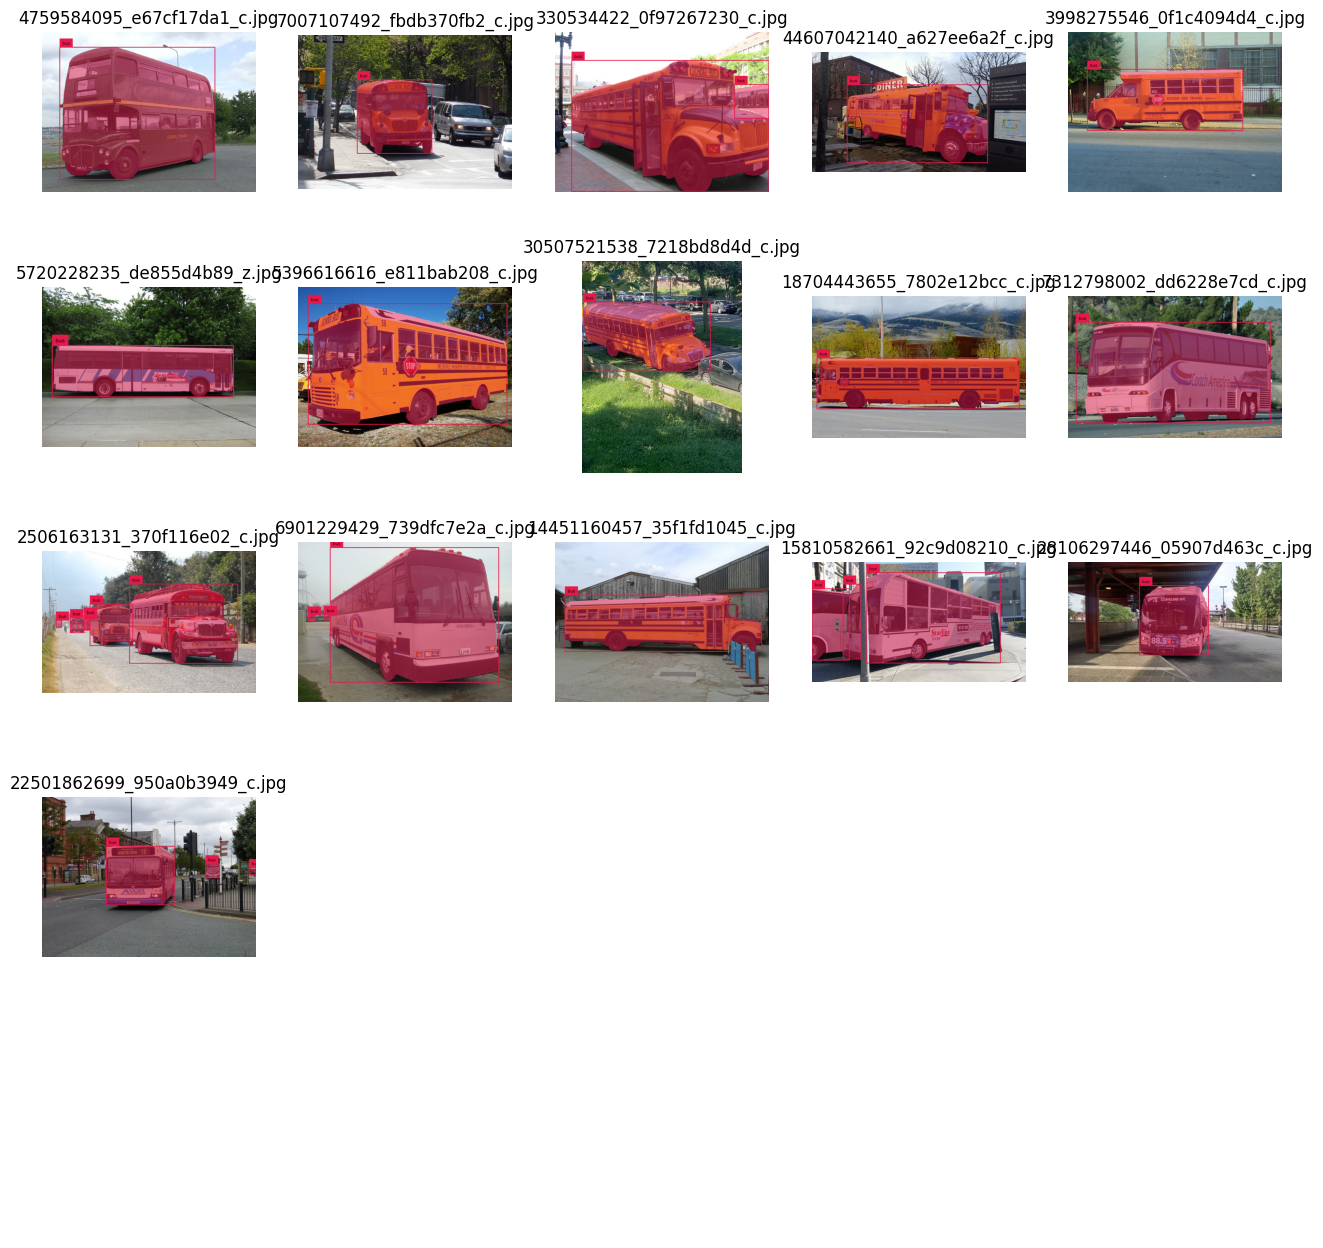

In [ ]:
process_images(ontology_1, "bus", 'output_inference')

# Train

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/Group-8-Deep-Learning/SAM/SAM-input-images/train/Copy of 2625877484_0c916cbd87_c.jpg: 100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


Labeled dataset created - ready for distillation.


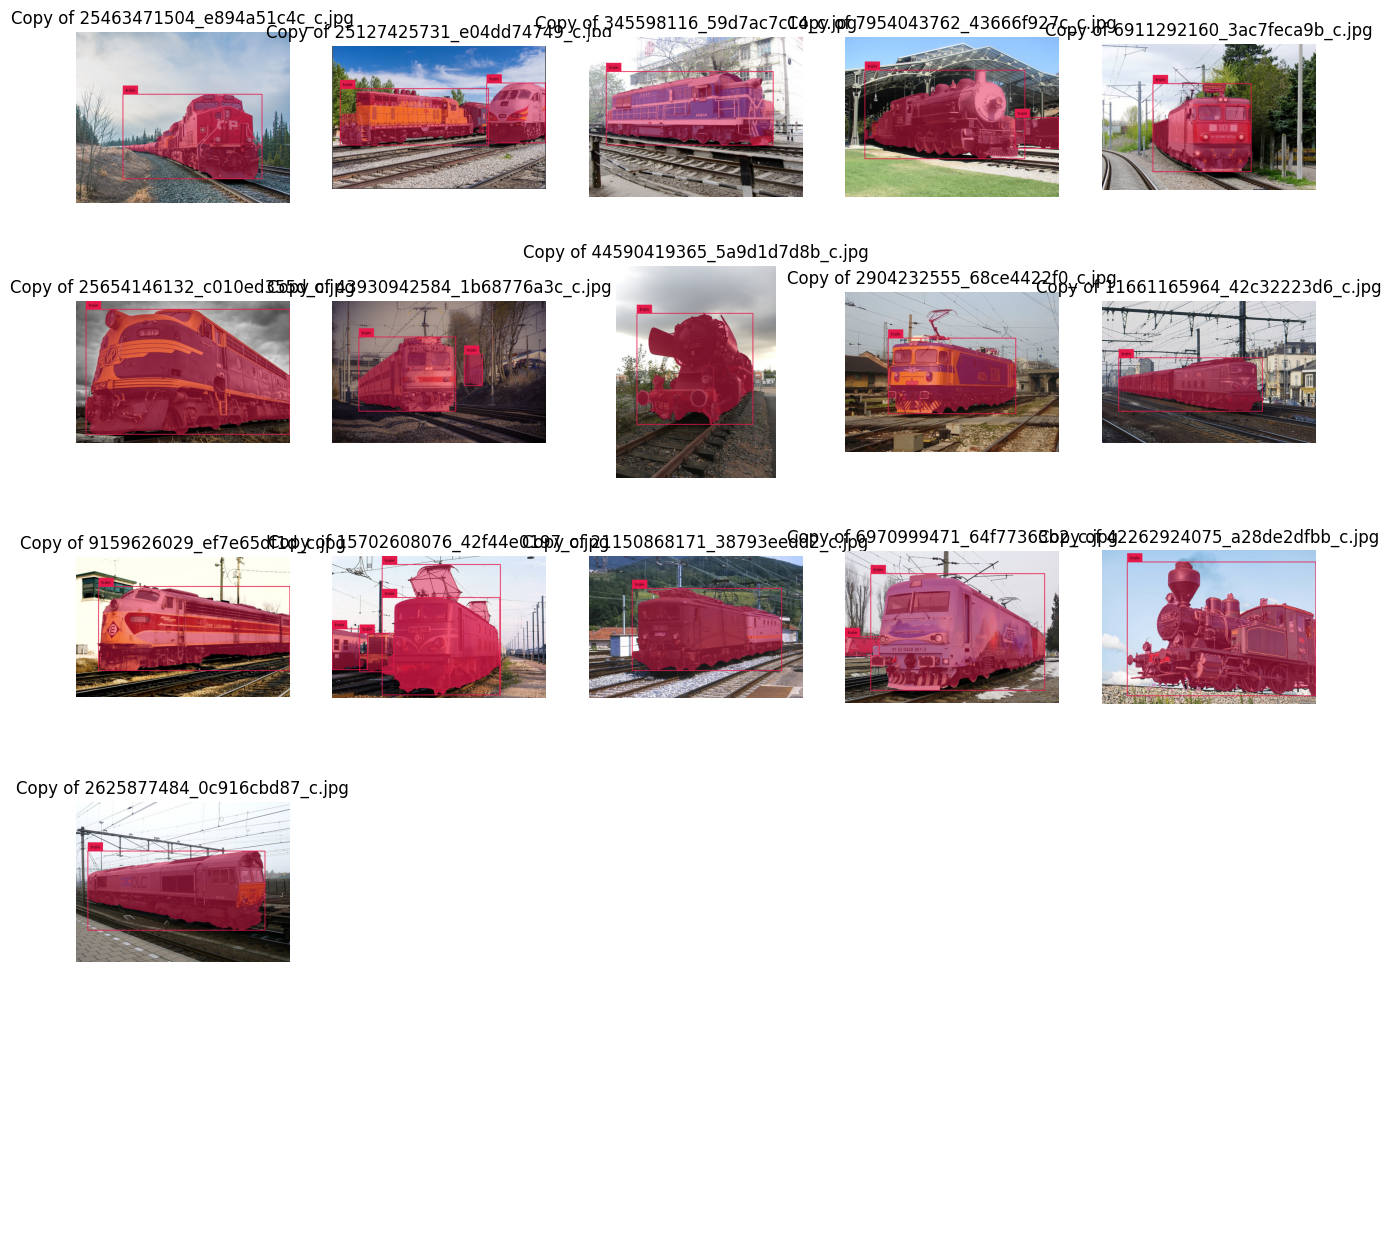

In [ ]:
process_images(ontology_2, "train", 'output_inference')

## Boat

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/Group-8-Deep-Learning/SAM/SAM-input-images/boat/Copy of 25408247030_39958bf278_z.jpg:   0%|          | 0/20 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /content/drive/MyDrive/Group-8-Deep-Learning/SAM/SAM-input-images/boat/Copy of 5126144554_b7d81ccb59_c.jpg: 100%|██████████| 20/20 [00:54<00:00,  2.73s/it]


Labeled dataset created - ready for distillation.


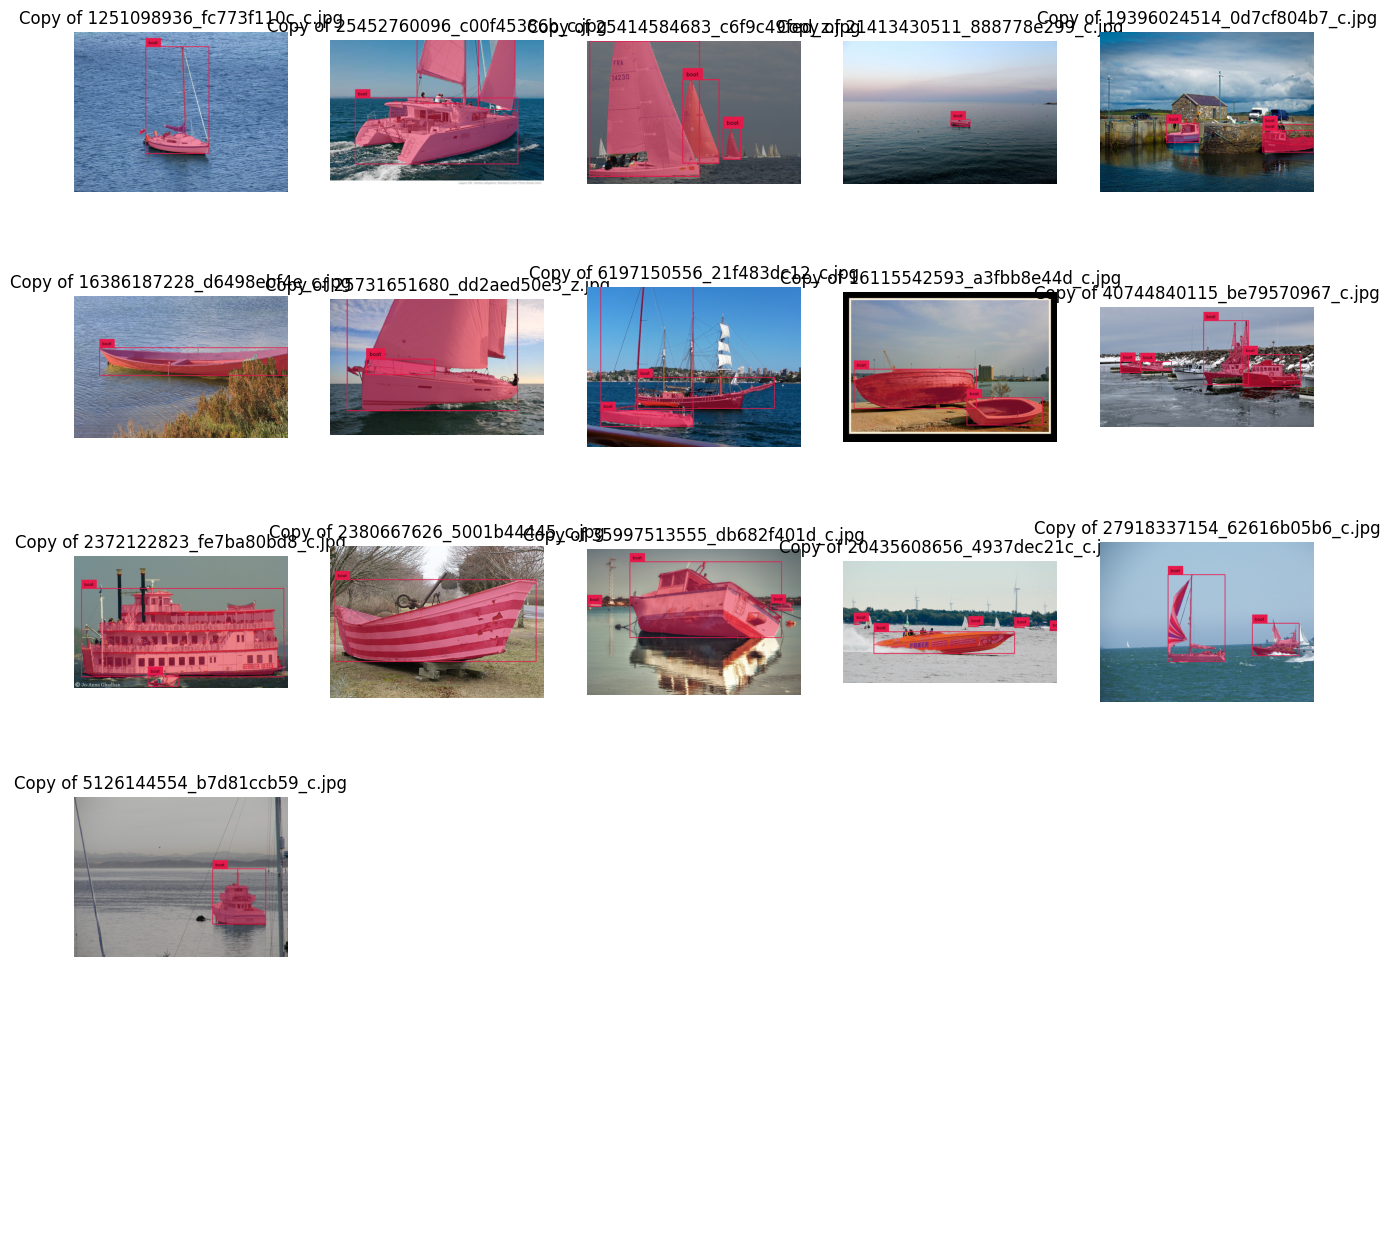

In [ ]:
process_images(ontology_3, "boat", 'output_inference')

## Person

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/Group-8-Deep-Learning/SAM/SAM-input-images/person/Copy of 377793983_43d3d59782_c.jpg: 100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Labeled dataset created - ready for distillation.


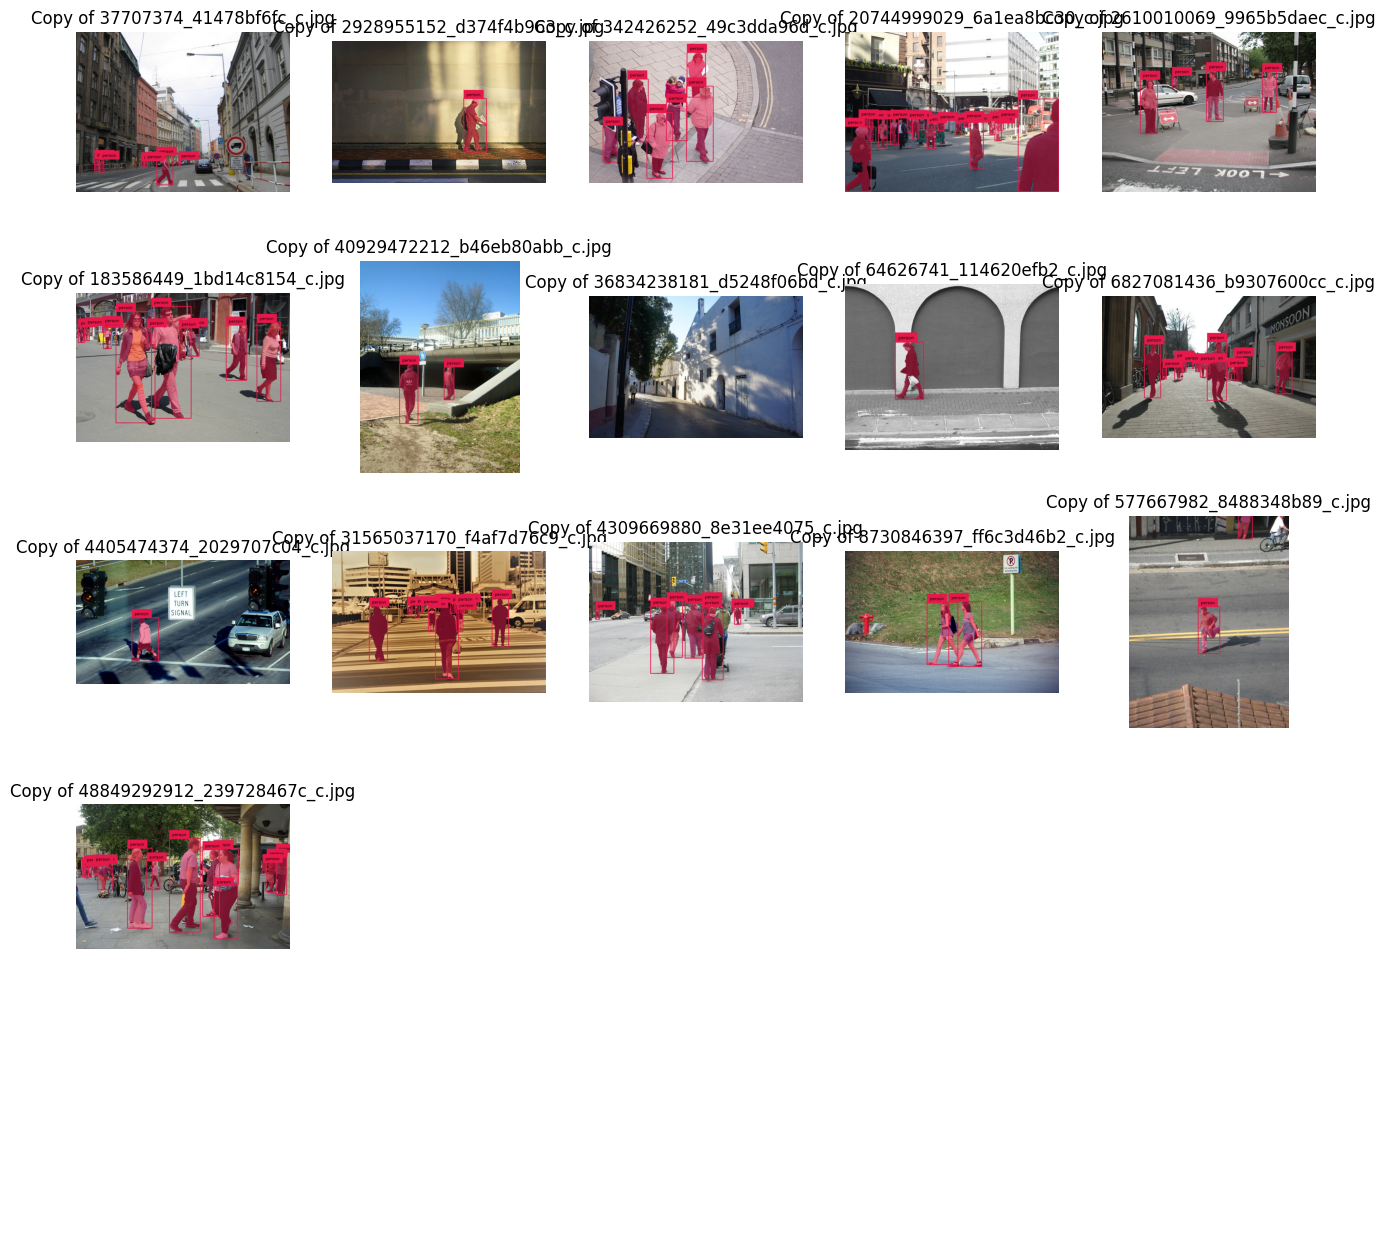

In [ ]:
process_images(ontology_4, "person", 'output_inference')